# NEURON Exercise: Inhibitory and Excitatory Synapses

Blue Brain Project / EPFL ©2005-2017. This notebook is under a [LGPLv3](https://raw.githubusercontent.com/BlueBrain/MOOC-neurons-and-synapses-2017/master/LICENSE.txt) license.

## Introduction

In this exercise, we will work the Exp2Syn synapse model included in NEURON, an implementation of a double exponential syanptic conductance profile, and explore some of its properties using simulation.

You will:
* Learn how to stimulate a synapse with a list of pre-synaptic spike times
* Review the difference between inhibitory and excitatory synapses

## Getting the NEURON simulator extensions (MOD files)

The week 4 exercises require user extensions to the NEURON simulator.  The NMODL language is a domain specific language of the NEURON simulator for the user to define such extensions, such as ion channels, synapse models, or stimulators.  To use NMODL, the user writes .mod files adhering to the NMODL language syntax (which can include verbatim C code).  These are programs external to python, and so must be editing using an external editor.

Here, we will fetch the .mod files required for the week 4 exercises from a public repository on github.
For editing your own .mod files, we suggest creating your own github account and repository, editing them locally on your computer, committing them to your github repository, and then fetching them as below.
This workflow has the important benefit that your .mod files are in a revision control system (git).

In [1]:
# Get a fresh install of the MOD files for week 4 by cloning the course git repo
!rm -rf MOOC-neurons-and-synapses-2017
!git clone https://github.com/BlueBrain/MOOC-neurons-and-synapses-2017

Cloning into 'MOOC-neurons-and-synapses-2017'...
remote: Enumerating objects: 509, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 509 (delta 10), reused 15 (delta 3), pack-reused 472
Receiving objects: 100% (509/509), 6.89 MiB | 7.94 MiB/s, done.
Resolving deltas: 100% (228/228), done.


## Compiling MOD files

MOD files need to be compiled before they can be used with NEURON.  
NEURON provides a tool called "nrnivmodl", which has the syntax:
```bash
$ nrnivmodl <directory>
```
Invocation will compile all `.mod` files found in `<directory>`, if specified, otherwise the current directory.

Our `.mod` files are located in "`./MOOC-neurons-and-synapses-2017/ModelingSynapses/mechanisms`", so we compile them as follows (the prefix `!` is used to invoke a system call outside python):

In [2]:
!nrnivmodl ./MOOC-neurons-and-synapses-2017/ModelingSynapses/mechanisms

Creating x86_64 directory for .o files.

/home/jovyan
./MOOC-neurons-and-synapses-2017/ModelingSynapses/mechanisms/SimpleAMPA_NMDA.mod ./MOOC-neurons-and-synapses-2017/ModelingSynapses/mechanisms/StochasticTsodyksMarkram_AMPA_NMDA.mod ./MOOC-neurons-and-synapses-2017/ModelingSynapses/mechanisms/TsodyksMarkram_AMPA_NMDA.mod ./MOOC-neurons-and-synapses-2017/ModelingSynapses/mechanisms/vecevent.mod
SimpleAMPA_NMDA.mod StochasticTsodyksMarkram_AMPA_NMDA.mod TsodyksMarkram_AMPA_NMDA.mod vecevent.mod
"/usr/local/nrn/x86_64/bin/nocmodl" SimpleAMPA_NMDA
Translating SimpleAMPA_NMDA.mod into SimpleAMPA_NMDA.c
Thread Safe
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -g -O2 -c -o SimpleAMPA_NMDA.lo SimpleAMPA_NMDA.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -g -O2 -c SimpleAMPA_NMDA.c  -fPIC -DPIC -o .libs/SimpleAMPA_NMDA.o
"/u

## nrnivmodl: Verify successful compilation

The output above indicates `nrnivmodl` completed successfully.  If error messages are generated, then something maybe wrong with `.mod` files you downloaded.  Double-check your .mod files, and try again. 

## Initialize NEURON

In [3]:
import neuron
from neuron import h
import numpy
import matplotlib.pyplot as plt
# Load external files & initialize
neuron.h.load_file("stdrun.hoc");
neuron.h.stdinit();

## A neuron to host your synapse

Following previous exercises, we will create a single compartment soma neuron to host the synapse.

In [4]:
soma = neuron.h.Section()
soma.L = 40
soma.diam = 40
soma.insert('pas')

In [5]:
# Configure the passive biophysics
for sec in h.allsec():
    sec.Ra = 100
    sec.cm = 1

Create a NEURON double exponential synapse at the center of the soma compartment (see [NEURON documentation](https://www.neuron.yale.edu/neuron/static/docs/help/neuron/neuron/mech.html#Exp2Syn) for more details).
This model has a rise time constant tau1 and a decay time constant tau2, and a reversal potential.  

In [6]:
synapse = h.Exp2Syn(soma(0.5))
synapse.tau1 = 0.5 # [ms]
synapse.tau2 = 10.0 # [ms]
synapse.e = -80.0 

Define the stimulus: 8 spikes at 20Hz + 1 spike 500 ms later

In [7]:
stimulator = h.VecStim()
spike_times = [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 950.0]
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

connection = h.NetCon(stimulator, synapse)
connection.weight[0] = 0.001        # [uS]

Create a recorder for the synaptic conductance, current, the soma voltage, and the time intervals

In [8]:
g_syn = h.Vector()
g_syn.record(synapse._ref_g)
i_syn = h.Vector()
i_syn.record(synapse._ref_i)
v_soma = h.Vector()
v_soma.record(soma(0.5)._ref_v)
time = h.Vector()
time.record(neuron.h._ref_t)

1.0

Now let's simulate, then we plot the conductance trajectories, and voltage trajectories.

In [9]:
h.tstop = 1000.0 # ms
neuron.h.run()

0.0

For convenience, lets define a plotting helper function

In [10]:
# This command gives us fancy interactive inline plots
%matplotlib notebook

def plot_timecourse(time_array, dependent_var, newfigure=True, show=True, label=None, ylabel='Membrane voltage (mV)', constants=[]):
    """Convenience function to plot time courses of dependent variables"""
    if newfigure:
        plt.figure()
    plt.plot(time_array, dependent_var, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel(ylabel)
    if show:
        plt.show()


The dual exponential model for the conductance time course has a closed form for the response due to a single pulse.
Below we validate the implementation running in NEURON against this closed form solution. 

<IPython.core.display.Javascript object>


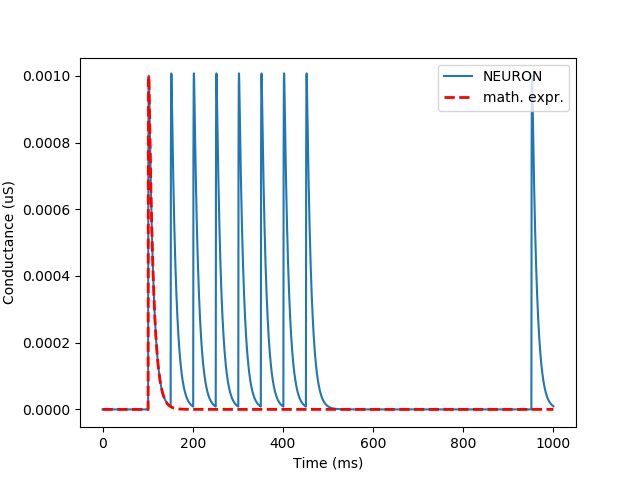

In [11]:

def dual_exp(t, tau_r, tau_d, t_start):
    """Compute the dual exponential time course using the closed form expression."""
    t = numpy.array(t)
    time_to_peak = (tau_r*tau_d)/(tau_d-tau_r)*numpy.log(tau_d/tau_r)
    factor = -numpy.exp(-time_to_peak/tau_r)+numpy.exp(-time_to_peak/tau_d)
    f_dual_exp = lambda t: (numpy.exp(-t/tau_d) - numpy.exp(-t/tau_r))/factor
    dual_exp = numpy.zeros_like(t)
    dual_exp[t>=t_start] = f_dual_exp(t[t>=t_start]-t_start)
    return dual_exp


plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="NEURON")

plt.plot(time, connection.weight[0]*dual_exp(time, synapse.tau1, synapse.tau2, 
                                                   t_start=100.0+connection.delay), 'r--', lw=2, label="math. expr.")
plt.legend()

Now let's plot the voltage for these synaptic conductance events.

<IPython.core.display.Javascript object>


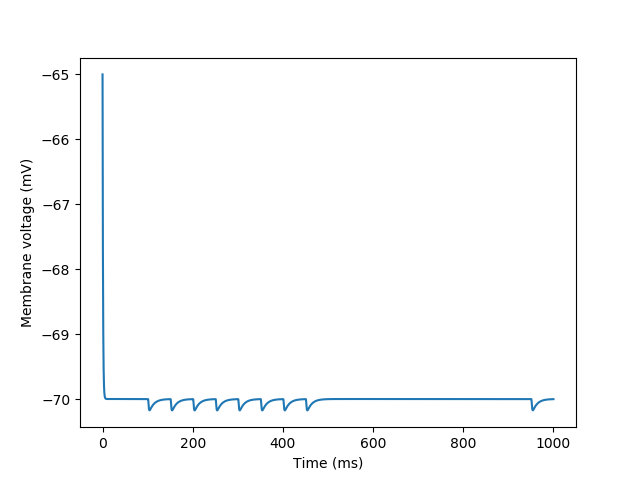

In [12]:
plot_timecourse(time, v_soma)

## Exercise

To submit answers to these questions and get feedback, please return to the edX platform.  

**Question 1**: Are you surprised??!  This is not an **excitatory** synapse (e.g. glutamatergic), but rather an **inhibitory** synapse (e.g. GABAergic).  Why is the soma voltage deflecting downwards for every synaptic pulse, rather than upwards?

**Question 2**: By changing only one parameter of the synapse, how can you make this an **excitatory** synapse? Convince yourself by re-running the simulation above.
